<a href="https://colab.research.google.com/github/pradyutsingh/semantic_segmentation/blob/master/semantic_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:



from __future__ import division
import numpy as np 
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = "/content/drive/My Drive/cityscapes_data/train"
validation_path = "/content/drive/My Drive/cityscapes_data/val"

In [0]:
#now lets load the images
def loadimage(name,path= train_path,size = (256,200), rotation=0.0,flip=False,cut_bottom=58):
    

    img = Image.open(path + "/" + name)
    img = np.array(img)
    # now we are the cutting the images into 2 parts/ one is the original image and one is the segmented image
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]

    for i in range(3):
        img1 = img[:,:,i]
        img1 = cv2.equalizeHist(img1)
        img[:,:,i]=img1
    

    #resizing the image
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)

    img=img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:

        img = img[:,::-1,:]
        seg = seg[:,::-1,:] 
    
    img = np.true_divide(img, 255)
    seg = np.true_divide(seg, 255)
    
    return img,seg
    

    

In [6]:
#now to find the most important colors and identify similar colors we will
#use k-means clustering algorithm
#we are going to use 13 clusters of colors to identify similar colors

files = os.listdir(train_path)[0:10]
colors = []

for file in files:
    img,seg = loadimage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1],3))

colors= np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

kmeans = KMeans(13)
kmeans.fit(colors)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
print(colors)

[[0.         0.02745098 0.00392157]
 [0.03529412 0.08235294 0.03529412]
 [0.         0.03137255 0.        ]
 ...
 [0.44705882 0.27843137 0.55686275]
 [0.42352941 0.25882353 0.50980392]
 [0.22352941 0.05882353 0.30588235]]


In [0]:
def layerToColors(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    ximg = np.zeros((img.shape[0],img.shape[1],3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]

        for j in range(3):
            ximg[:,:,j] +=col[j]*c

    ximg = ximg/255
    return ximg  


    

In [0]:
#now this function converts the output of the kmeans clustering to 13-dimensional class representation
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = kmeans.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(kmeans.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

<function matplotlib.pyplot.show>

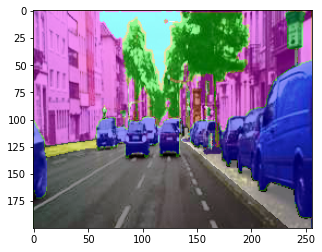

In [10]:
img,seg= loadimage("123.jpg")
seg2 = ColorsToClass(seg)
seg2 = layerToColors(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show


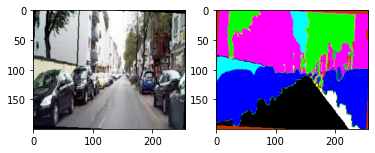

In [11]:

def Generate(path=train_path, batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = loadimage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(layerToColors(segs[0]))
plot.show()

In [12]:
#now we are gonna use the unet architecture to implement semantic segmentation
input = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(input)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)



x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)



x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)

p3 = MaxPooling2D()(x3)



x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)


x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(input, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()











Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 256, 64) 27712       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 200, 256, 128 1179776     conv2d_1[0][0]                   
___________________________________________________________________________________

In [0]:
train_gen = Generate()
val_gen = Generate(validation_path)

In [0]:
clb = [ModelCheckpoint("/content/drive/My Drive/loss.h5", save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=100, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
